In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(11)
import json
import os
from read_O3_LVK_results import *

In [2]:
precomputed_data = "stored_lnm1_q_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    m1s = traces['m1s']
    qs = traces['qs']
    dR_dlnm1s_q1 = traces['dR_dlnm1s_q1']
    dR_dqs_lnm20 = traces['dR_dqs_lnm20']
    R_ref = traces['R_ref']
    f_lnm1s = traces['f_lnm1s']
    f_qs = traces['f_qs']
    kappa = traces['kappa']
    mu_chi = traces['mu_chi']
    logsig_chi = traces['logsig_chi']
    sig_cost = traces['sig_cost']
    
else:

    # Load inference data
    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_lnm1_q.cdf")
    samps = inference_data.posterior.stack(draws=("chain", "draw"))

    # Also extract mass and mass ratio values
    lnm1_q_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_lnm1_q_data.npy',allow_pickle=True)[()]
    m1_values = np.exp(lnm1_q_data['all_lnm1_samples'])
    q_values = lnm1_q_data['all_q_samples']

    # For ease of plotting, coarse-grain by a factor of 50
    m1s = m1_values[::50]
    f_lnm1s = samps['f_lnm1s'][::50,:]

    R_ref = samps['R20']
    f_q1 = samps['f_qs'][-1,:]

    # Compute rate density over m1, at fixed q=1
    dR_dlnm1s_q1 = np.zeros((m1s.size,f_lnm1s.shape[1]))
    for i in range(f_lnm1s.shape[1]):
        dR_dlnm1s_q1[:,i] = R_ref[i]*f_lnm1s[:,i]*f_q1[i]

    # For ease of plotting, coarse-grain by a factor of 50
    qs = q_values[::50]
    f_qs = samps['f_qs'][::50]
    f_m20 = samps['f_lnm1s'][lnm1_q_data['ind_m20'],:]

    # Compute probability density
    dR_dqs_lnm20 = np.zeros((qs.size,f_qs.shape[1]))
    for i in range(f_qs.shape[1]):
        dR_dqs_lnm20[:,i] = R_ref[i]*f_m20[i]*f_qs[:,i]

    traces = {
        'qs':qs,
        'm1s':m1s,
        'dR_dlnm1s_q1':dR_dlnm1s_q1,
        'dR_dqs_lnm20':dR_dqs_lnm20,
        'R_ref':R_ref,
        'f_lnm1s':f_lnm1s,
        'f_qs':f_qs,
        'R_ref':samps['R20'].values,
        'kappa':samps['kappa'].values,
        'mu_chi':samps['mu_chi'].values,
        'logsig_chi':samps['logsig_chi'].values,
        'sig_cost':samps['sig_cost'].values
        }

    np.save('stored_lnm1_q_data.npy',traces)

In [3]:
lvk_m1_grid,lvk_q_grid,lvk_R_m1s_qs = get_lvk_m1_q(1000)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:182: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:192: RuntimeWarning: invalid value encountered in true_divide
  p_q = p_q_unnormed/np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/

In [3]:
ind_lnm_7p5 = np.argmin(np.abs(m1s-7.5))
ind_lnm_9 = np.argmin(np.abs(m1s-9.))
ind_lnm_11 = np.argmin(np.abs(m1s-11.))
ind_lnm_13p5 = np.argmin(np.abs(m1s-13.5))

mean_R_7p5_to_9 = np.trapz(dR_dlnm1s_q1[ind_lnm_7p5:ind_lnm_9,:],np.log10(m1s[ind_lnm_7p5:ind_lnm_9]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_7p5:ind_lnm_9]),np.log10(m1s[ind_lnm_7p5:ind_lnm_9]))

mean_R_9_to_11 = np.trapz(dR_dlnm1s_q1[ind_lnm_9:ind_lnm_11,:],np.log10(m1s[ind_lnm_9:ind_lnm_11]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_9:ind_lnm_11]),np.log10(m1s[ind_lnm_9:ind_lnm_11]))

mean_R_11_to_13p5 = np.trapz(dR_dlnm1s_q1[ind_lnm_11:ind_lnm_13p5,:],np.log10(m1s[ind_lnm_11:ind_lnm_13p5]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_11:ind_lnm_13p5]),np.log10(m1s[ind_lnm_11:ind_lnm_13p5]))

mid_vs_low_10Msun = mean_R_9_to_11/mean_R_7p5_to_9
mid_vs_high_10Msun = mean_R_9_to_11/mean_R_11_to_13p5

print(np.sum((mid_vs_low_10Msun>1)*(mid_vs_high_10Msun>1))/mid_vs_low_10Msun.size)

0.9291111111111111


In [4]:
ind_lnm_20 = np.argmin(np.abs(m1s-20.))
ind_lnm_28 = np.argmin(np.abs(m1s-28.))
ind_lnm_40 = np.argmin(np.abs(m1s-40.))
ind_lnm_55 = np.argmin(np.abs(m1s-55.))

mean_R_20_to_28 = np.trapz(dR_dlnm1s_q1[ind_lnm_20:ind_lnm_28,:],np.log10(m1s[ind_lnm_20:ind_lnm_28]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_20:ind_lnm_28]),np.log10(m1s[ind_lnm_20:ind_lnm_28]))

mean_R_28_to_40 = np.trapz(dR_dlnm1s_q1[ind_lnm_28:ind_lnm_40,:],np.log10(m1s[ind_lnm_28:ind_lnm_40]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_28:ind_lnm_40]),np.log10(m1s[ind_lnm_28:ind_lnm_40]))

mean_R_40_to_55 = np.trapz(dR_dlnm1s_q1[ind_lnm_40:ind_lnm_55,:],np.log10(m1s[ind_lnm_40:ind_lnm_55]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_40:ind_lnm_55]),np.log10(m1s[ind_lnm_40:ind_lnm_55]))

mid_vs_low_35Msun = mean_R_28_to_40/mean_R_20_to_28
mid_vs_high_35Msun = mean_R_28_to_40/mean_R_40_to_55

print(np.sum((mid_vs_low_35Msun>1)*(mid_vs_high_35Msun>1))/mid_vs_low_35Msun.size)

0.9193333333333333


In [5]:
ind_lnm_15 = np.argmin(np.abs(m1s-15.))
ind_lnm_16 = np.argmin(np.abs(m1s-16.))
mean_R_15_to_16 = np.trapz(dR_dlnm1s_q1[ind_lnm_15:ind_lnm_16,:],np.log10(m1s[ind_lnm_15:ind_lnm_16]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_15:ind_lnm_16]),np.log10(m1s[ind_lnm_15:ind_lnm_16]))

ind_lnm_24 = np.argmin(np.abs(m1s-24.))
ind_lnm_25 = np.argmin(np.abs(m1s-25.))
mean_R_24_to_25 = np.trapz(dR_dlnm1s_q1[ind_lnm_24:ind_lnm_25,:],np.log10(m1s[ind_lnm_24:ind_lnm_25]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_24:ind_lnm_25]),np.log10(m1s[ind_lnm_24:ind_lnm_25]))

ind_lnm_45 = np.argmin(np.abs(m1s-45.))
ind_lnm_46 = np.argmin(np.abs(m1s-46.))
mean_R_45_to_46 = np.trapz(dR_dlnm1s_q1[ind_lnm_45:ind_lnm_46,:],np.log10(m1s[ind_lnm_45:ind_lnm_46]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_45:ind_lnm_46]),np.log10(m1s[ind_lnm_45:ind_lnm_46]))

ind_lnm_69 = np.argmin(np.abs(m1s-69.))
ind_lnm_70 = np.argmin(np.abs(m1s-70.))
mean_R_69_to_70 = np.trapz(dR_dlnm1s_q1[ind_lnm_69:ind_lnm_70,:],np.log10(m1s[ind_lnm_69:ind_lnm_70]),axis=0)/\
    np.trapz(np.ones_like(m1s[ind_lnm_69:ind_lnm_70]),np.log10(m1s[ind_lnm_69:ind_lnm_70]))

slope_15_to_25 = np.log10(mean_R_24_to_25/mean_R_15_to_16)/np.log10(25./15.)
slope_45_to_70 = np.log10(mean_R_69_to_70/mean_R_45_to_46)/np.log10(70./45.)

print(np.mean(slope_15_to_25),np.mean(slope_45_to_70),np.sum(slope_45_to_70<slope_15_to_25)/slope_15_to_25.size)

-1.0668843384821503 -3.630785655357733 0.8726666666666667


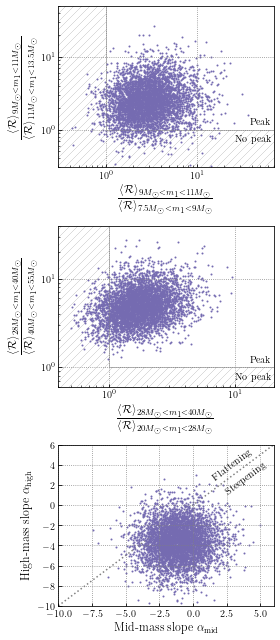

In [6]:
fig = plt.figure(figsize=(4,9))

ax = fig.add_subplot(311)
ax.set_rasterization_zorder(1)
ax.scatter(mid_vs_low_10Msun,mid_vs_high_10Msun,s=1,color='#756bb1',zorder=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.3,70)
ax.set_ylim(0.3,50)

ax.set_xlabel(r'$\frac{\langle \mathcal{R}\rangle_{9 M_\odot<m_1<11 M_\odot}}{\langle \mathcal{R}\rangle_{7.5 M_\odot<m_1<9 M_\odot}}$',
             fontsize=17)
ax.set_ylabel(r'$\frac{\langle \mathcal{R}\rangle_{9 M_\odot<m_1<11 M_\odot}}{\langle \mathcal{R}\rangle_{11 M_\odot<m_1<13.5 M_\odot}}$',
             fontsize=17)

ax.text(0.99, 0.25, 'Peak',
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.text(0.99, 0.15, 'No peak',
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.fill_between([0.3,70],[1,1],hatch='///',facecolor='None',zorder=-1,linewidth=0)
ax.fill_betweenx([1,50],[1,1],hatch='///',facecolor='None',zorder=-1,linewidth=0)
ax.plot([1,1,70],[50,1,1],color='grey',zorder=-1,lw=0.5)

ax = fig.add_subplot(312)
ax.set_rasterization_zorder(1)
ax.scatter(mid_vs_low_35Msun,mid_vs_high_35Msun,s=1,color='#756bb1',zorder=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.4,20)
ax.set_ylim(0.6,40)

ax.set_xlabel(r'$\frac{\langle \mathcal{R}\rangle_{28 M_\odot<m_1<40 M_\odot}}{\langle \mathcal{R}\rangle_{20 M_\odot<m_1<28 M_\odot}}$',
             fontsize=17)
ax.set_ylabel(r'$\frac{\langle \mathcal{R}\rangle_{28 M_\odot<m_1<40 M_\odot}}{\langle \mathcal{R}\rangle_{40 M_\odot<m_1<55 M_\odot}}$',
             fontsize=17)

ax.text(0.99, 0.135, 'Peak',
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.text(0.99, 0.035, 'No peak',
        verticalalignment='bottom',
        horizontalalignment='right',
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.fill_between([0.4,40],[1,1],hatch='///',facecolor='None',zorder=-1,linewidth=0)
ax.fill_betweenx([1,40],[1,1],hatch='///',facecolor='None',zorder=-1,linewidth=0)
ax.plot([1,1,40],[40,1,1],color='grey',zorder=-1,lw=0.5)

ax = fig.add_subplot(313)
ax.set_rasterization_zorder(1)
ax.scatter(slope_15_to_25,slope_45_to_70,s=1,color='#756bb1',zorder=0)
ax.set_xlim(-10,6)
ax.set_ylim(-10,6)

ax.set_xlabel(r'Mid-mass slope $\alpha_\mathrm{mid}$')#,fontsize=14)
ax.set_ylabel(r'High-mass slope $\alpha_\mathrm{high}$')#,fontsize=14)

ax.text(0.9, 0.77, 'Flattening',
        verticalalignment='bottom',
        horizontalalignment='right',
        rotation=37.,
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.text(0.97, 0.68, 'Steepening',
        verticalalignment='bottom',
        horizontalalignment='right',
        rotation=37.,
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.plot([-10,6],[-10,6],color='grey',ls=':',zorder=-1)

plt.tight_layout()
plt.savefig('mass_features.pdf',dpi=200,bbox_inches='tight')

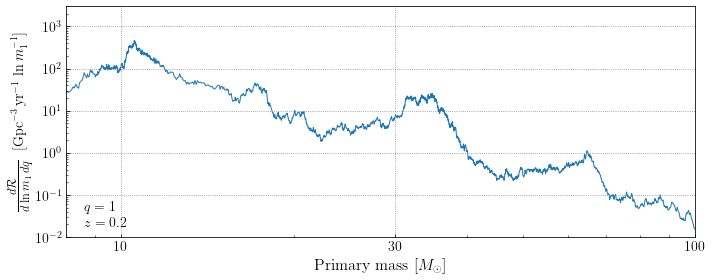

In [7]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)
      
ax.plot(m1s,dR_dlnm1s_q1[:,50],color='#1f78b4',alpha=1,lw=1,zorder=0)

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.tight_layout()
plt.show()

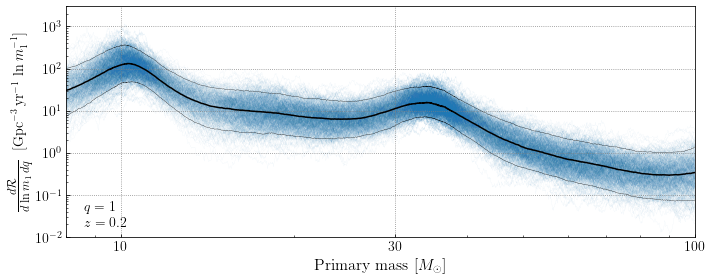

In [3]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)
      
for i in np.random.choice(range(dR_dlnm1s_q1.shape[1]),size=500,replace=False):                 
    ax.plot(m1s,dR_dlnm1s_q1[:,i],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)

ax.plot(m1s,np.median(dR_dlnm1s_q1,axis=1),color='black')
ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),color='black',lw=0.3)
ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

#ax.plot(m1s,10.*(m1s/15.)**(-1.14),ls=':',color='black')
#ax.plot(m1s,3.*(m1s/45.)**(-3.84),ls=':',color='black')

plt.tight_layout()
plt.savefig('lnm1.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [4]:
from scipy.optimize import minimize

def broken_power_law(m1s,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin):
    
    bpl = np.where(m1s<mBreak,(m1s/mBreak)**lmbda1,(m1s/mBreak)**lmbda2)
    
    tapering = np.exp(-(m1s-mMin)**2/(2.*dmMin**2))
    bpl = np.where(m1s<mMin,bpl*tapering,bpl)
    
    bpl[m1s>mMax] = 0
    
    return bpl

def model(m1,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin):
    
    m1_grid = np.linspace(2,100,1000)
    bpl_grid = broken_power_law(m1_grid,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)
    bpl_norm = np.trapz(bpl_grid,m1_grid)
    
    bpl = broken_power_law(m1,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)/bpl_norm
    
    peak_1 = np.exp(-(m1-mu1)**2/(2.*sig1**2))/np.sqrt(2.*np.pi*sig1**2)
    peak_2 = np.exp(-(m1-mu2)**2/(2.*sig2**2))/np.sqrt(2.*np.pi*sig2**2)
    
    p_m1 = f_peak_1*peak_1 + f_peak_2*peak_2 + (1.-f_peak_1-f_peak_2)*bpl
    return p_m1

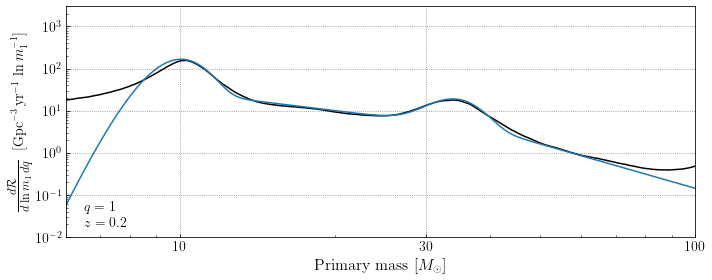

In [48]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)
      
ax.plot(m1s,np.mean(dR_dlnm1s_q1,axis=1),color='black')

f_peak_1 = 0.48
f_peak_2 = 0.15
mu1 = 10
sig1 = 1.
mu2 = 34.
sig2 = 3.5
lmbda1 = -1.5
lmbda2 = -3.5
mBreak = 40
mMin = 12.
mMax = 100
dmMin = 1

test_pm1 = model(m1s,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)
test_pm1_ref = model(20.,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)

ax.plot(m1s,test_pm1*10./test_pm1_ref)

ax.tick_params(labelsize=14)
ax.set_xlim(6,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.tight_layout()
plt.show()

In [49]:
m1s_high = m1s[(m1s>8)*(m1s<90)]
R_m1_target = np.mean(dR_dlnm1s_q1,axis=1)[(m1s>8)*(m1s<90)]

def ls(params):
    
    R_20,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin = params
    
    R_m1_model = model(m1s_high,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)
    R_m1_model_ref = model(20.,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)
    R_m1_model = R_m1_model*(R_20/R_m1_model_ref)
    
    return np.trapz((np.log(R_m1_target)-np.log(R_m1_model))**2,m1s_high)

initial_params = (10.,f_peak_1,f_peak_2,mu1,sig1,mu2,sig2,lmbda1,lmbda2,mBreak,mMin,mMax,dmMin)
bounds = [(None,None) for param in initial_params]
bounds[-2] = (100,100)
bounds[-1] = (0.5,10)

soln = minimize(ls,initial_params,method='Nelder-Mead',bounds=bounds,options={'maxiter':1e4})

In [50]:
fitted_R0,fitted_fp1,fitted_fp2,\
    fitted_mu1,fitted_sig1,fitted_mu2,fitted_sig2,\
    fitted_l1,fitted_l2,fitted_mBreak,fitted_mMin,fitted_mMax,fitted_dmMin = soln.x

print(fitted_fp1,fitted_mu1,fitted_sig1)
print(fitted_fp2,fitted_mu2,fitted_sig2)
print(fitted_mMin,fitted_mBreak,fitted_mMax)
print(fitted_dmMin,fitted_l1,fitted_l2)

0.4283732427675002 9.963256802990152 1.1873873386123108
0.1796261928466633 33.94070932843054 4.564472755048326
10.33427135994371 45.133360603949114 100.0
0.5000002190913502 -1.7905065978573318 -2.72602126427022


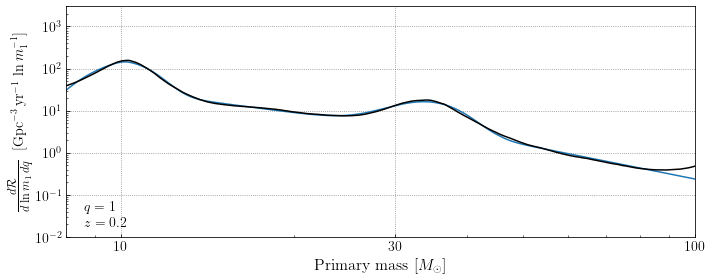

In [63]:
fig,ax = plt.subplots(figsize=(10,4))

R_m1_model = model(m1s,(*soln.x[1:]))
R_m1_model_ref = model(20.,(*soln.x[1:]))
R_m1_model = R_m1_model*(soln.x[0]/R_m1_model_ref)
ax.plot(m1s,R_m1_model)

ax.plot(m1s,np.mean(dR_dlnm1s_q1,axis=1),color='black')

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.tight_layout()
plt.show()

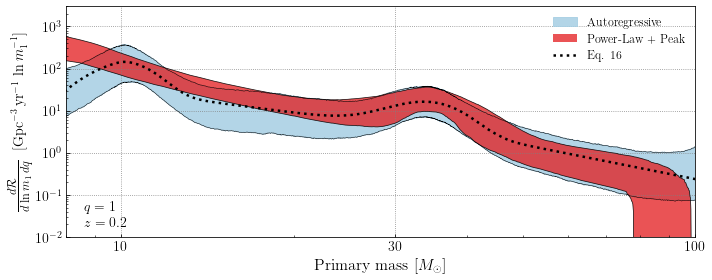

In [68]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)

ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),color='black',lw=0.5)
ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(m1s,
                np.quantile(dR_dlnm1s_q1,0.05,axis=1),
                np.quantile(dR_dlnm1s_q1,0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=-1,
                label='Autoregressive')

ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,
                color='#e31a1c',alpha=0.75,zorder=1,lw=0,
                label='Power-Law + Peak')

ax.plot(m1s,R_m1_model,color='black',ls=':',lw=2.5,label='Eq. 16')

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend(loc='upper right')

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.tight_layout()
plt.savefig('lnm1_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [69]:
test = read_lvk_plpeak_data()
for key in test.keys():
    print(key,np.mean(test[key]))

alpha 3.5257636142139273
mMax 87.9636269540623
mMin 4.915686939725657
fPeak 0.04346763583344784
mu_m1 33.31661961716097
sig_m1 4.876129374310264
delta_m 4.996081633492029
bq 1.168532682351534
kappa 2.873120813746975
Rtot 17.512251495000296
mu_chi 0.28159835190060223
sig_chi 0.18121731192768198
sig_cost 1.768735216188058
f_aligned 0.6120669543359246


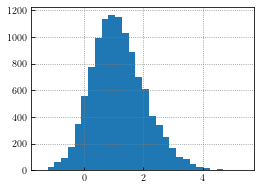

0.9188125894134478


In [73]:
plt.hist(test['bq'],bins=30)
plt.show()

bq = test['bq']
print(bq[bq>0].size/bq.size)

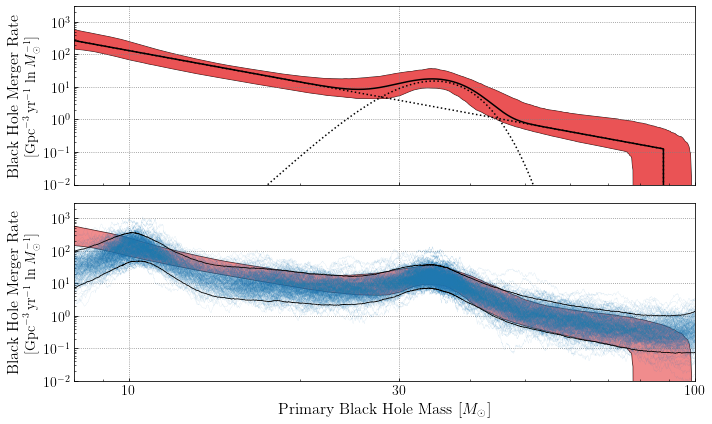

In [93]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(211)
ax.set_rasterization_zorder(1)


ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=-2)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=-2)
ax.fill_between(lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,
                color='#e31a1c',alpha=0.75,zorder=-1,lw=0)

alpha = -4.2
mMax = 87.96
mMin = 4.9
fPeak = 0.05
mu_m1 = 34.
sig_m1 = 4.5
Rtot = 16.87
kappa = 2.875
bq = 1.09

pl_m1 = (1.+alpha)*lvk_m1_grid**alpha/(mMax**(1.+alpha) - mMin**(1.+alpha))
pl_m1[(lvk_m1_grid<mMin)+(lvk_m1_grid>mMax)] = 0.
peak_m1 = np.exp(-(lvk_m1_grid-mu_m1)**2/(2.*sig_m1**2))/np.sqrt(2.*np.pi*sig_m1**2)
p_m1 = fPeak*peak_m1 + (1.-fPeak)*pl_m1

ind_m30 = np.argmin(np.abs(lvk_m1_grid-30.))
p_m1 *= 1./p_m1[ind_m30]

ax.plot(lvk_m1_grid,5.*peak_m1*lvk_m1_grid,color='black',ls=':')
ax.plot(lvk_m1_grid,400.*pl_m1*lvk_m1_grid,color='black',ls=':')
ax.plot(lvk_m1_grid,5.*peak_m1*lvk_m1_grid + 400.*pl_m1*lvk_m1_grid,color='black')

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticklabels([])
ax.set_ylabel('Black Hole Merger Rate \n \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln M_\odot^{-1}$]}',fontsize=16)



ax = fig.add_subplot(212)
ax.set_rasterization_zorder(1)
      
for i in np.random.choice(range(dR_dlnm1s_q1.shape[1]),size=250,replace=False):                 
    ax.plot(m1s,dR_dlnm1s_q1[:,i],color='#1f78b4',alpha=0.5,lw=0.1,zorder=2)

ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),color='black',lw=0.8,zorder=3)
ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='black',lw=0.8,zorder=3)

ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=-2)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=-2)
ax.fill_between(lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,
                color='#e31a1c',alpha=0.5,zorder=-1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel('Primary Black Hole Mass [$M_\odot$]',fontsize=16)
ax.set_ylabel('Black Hole Merger Rate \n \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln M_\odot^{-1}$]}',fontsize=16)
              #$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.tight_layout()
plt.savefig('test.pdf',bbox_inches='tight',dpi=200)
plt.show()

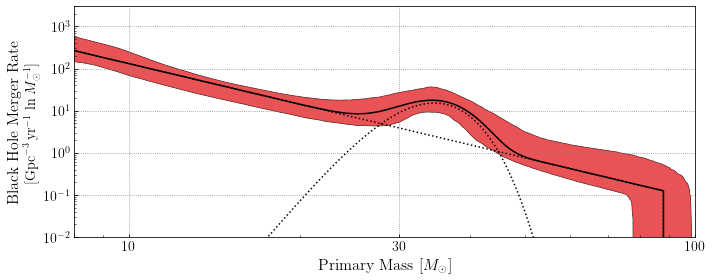

In [5]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)


ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=-2)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,color='black',lw=0.75,alpha=0.9,zorder=-2)
ax.fill_between(lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,
                color='#e31a1c',alpha=0.75,zorder=-1,lw=0)

alpha = -4.2
mMax = 87.96
mMin = 4.9
fPeak = 0.05
mu_m1 = 34.
sig_m1 = 4.5
Rtot = 16.87
kappa = 2.875
bq = 1.09

pl_m1 = (1.+alpha)*lvk_m1_grid**alpha/(mMax**(1.+alpha) - mMin**(1.+alpha))
pl_m1[(lvk_m1_grid<mMin)+(lvk_m1_grid>mMax)] = 0.
peak_m1 = np.exp(-(lvk_m1_grid-mu_m1)**2/(2.*sig_m1**2))/np.sqrt(2.*np.pi*sig_m1**2)
p_m1 = fPeak*peak_m1 + (1.-fPeak)*pl_m1

ind_m30 = np.argmin(np.abs(lvk_m1_grid-30.))
p_m1 *= 1./p_m1[ind_m30]

ax.plot(lvk_m1_grid,5.*peak_m1*lvk_m1_grid,color='black',ls=':')
ax.plot(lvk_m1_grid,400.*pl_m1*lvk_m1_grid,color='black',ls=':')
ax.plot(lvk_m1_grid,5.*peak_m1*lvk_m1_grid + 400.*pl_m1*lvk_m1_grid,color='black')

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel('Black Hole Merger Rate \n \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln M_\odot^{-1}$]}',fontsize=16)
ax.set_xlabel('Primary Mass [$M_\odot$]',fontsize=16)

plt.tight_layout()
plt.savefig('test2.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
### fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

for i in np.random.choice(range(dR_dqs_lnm20.shape[1]),size=500,replace=False):                 
    ax.plot(qs,dR_dqs_lnm20[:,i],color='#1f78b4',alpha=0.3,lw=0.1,zorder=0)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.4)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Mass ratio $q$',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.savefig('q_rate.pdf',bbox_inches='tight',dpi=200)
plt.show()

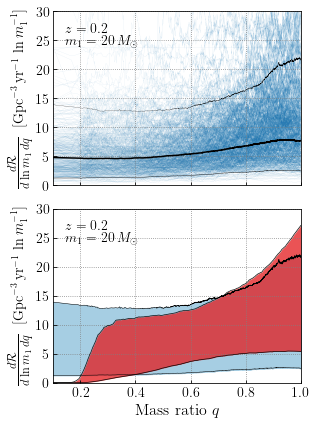

In [8]:
fig = plt.figure(figsize=(4.5,6))

ax = fig.add_subplot(211)
ax.set_rasterization_zorder(1)

for i in np.random.choice(range(dR_dqs_lnm20.shape[1]),size=500,replace=False):                 
    ax.plot(qs,dR_dqs_lnm20[:,i],color='#1f78b4',alpha=0.3,lw=0.1,zorder=0)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.4)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)
ax.set_xticklabels([])

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(212)
ax.set_rasterization_zorder(1)

ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.5)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),
                np.quantile(dR_dqs_lnm20,0.95,axis=1),
                color='#a6cee3',zorder=-1)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-30.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*30.

ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_q_grid,
                np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Mass ratio $q$',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.tight_layout()
plt.savefig('q_rate.pdf',bbox_inches='tight',dpi=200)
plt.show()

/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_92695/2791909305.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.pcolormesh(m1s,qs,np.log10(R.T),cmap='Blues',vmin=-4,vmax=1.5)
/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_92695/2791909305.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolormesh(m1s,qs,np.log10(R.T),cmap='Blues',vmin=-4,vmax=1.5)
/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_92695/2791909305.py:11: RuntimeWarning: divide by zero encountered in log10
  ax.contour(lvk_m1_grid,lvk_q_grid,np.log10(lvk_R_m1s_qs[400,:,:]),levels=np.linspace(-4,2,30))


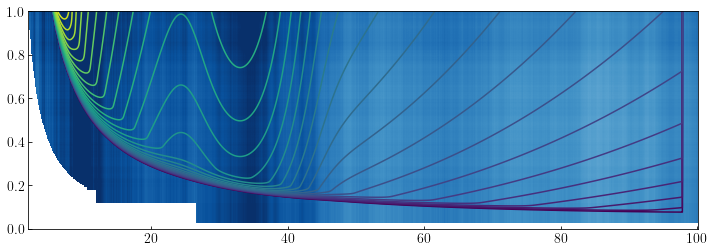

In [105]:
i=30

Q,M1 = np.meshgrid(qs,m1s)
M2 = Q*M1

R = R_ref.values[i]*np.outer(f_lnm1s[:,i],f_qs[:,i])
R[M2<2] = 0

fig,ax = plt.subplots(figsize=(12,4))
ax.pcolormesh(m1s,qs,np.log10(R.T),cmap='Blues',vmin=-4,vmax=1.5)
ax.contour(lvk_m1_grid,lvk_q_grid,np.log10(lvk_R_m1s_qs[400,:,:]),levels=np.linspace(-4,2,30))

In [163]:
i=500

Q,M1 = np.meshgrid(qs,m1s)
M2 = Q*M1

R1 = R_ref.values[i]*np.outer(f_lnm1s[:,i],f_qs[:,i])
R2 = R_ref.values[i]*np.outer(f_lnm1s[:,i],f_qs[:,i])
R1[M2<2] = 0
R2[M2<2] = 0

pq1 = np.trapz(R1/m1s[:,np.newaxis],m1s,axis=0)
pq1 /= np.trapz(pq1,qs)

pq2 = np.trapz(R2/m1s[:,np.newaxis],m1s,axis=0)
pq2 /= np.trapz(pq2,qs)

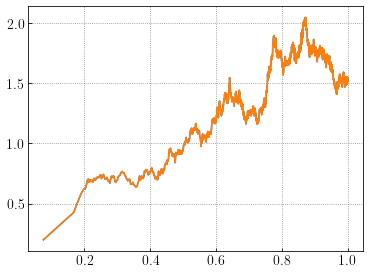

In [164]:
fig,ax = plt.subplots()
ax.plot(qs,pq1)
ax.plot(qs,pq2)

In [165]:
p_qs = np.zeros((qs.size,300))#f_lnm1s.shape[1]))

Q,M1 = np.meshgrid(qs,m1s)
M2 = Q*M1

for i in range(300):#f_lnm1s.shape[1]):
    
    R = R_ref.values[i]*np.outer(f_lnm1s[:,i],f_qs[:,i])
    R[M2<3] = 0
    
    p_q = np.trapz(R/m1s[:,np.newaxis],m1s,axis=0)
    p_q /= np.trapz(p_q,qs)
    p_qs[:,i] = p_q

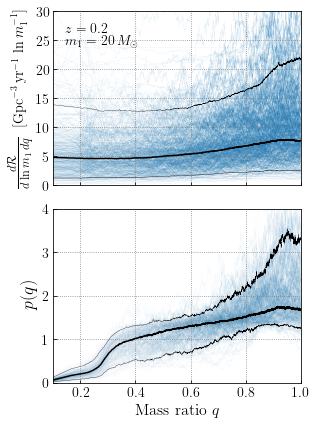

In [166]:
fig = plt.figure(figsize=(4.5,6))

ax = fig.add_subplot(211)
ax.set_rasterization_zorder(1)

for i in np.random.choice(range(dR_dqs_lnm20.shape[1]),size=500,replace=False):                 
    ax.plot(qs,dR_dqs_lnm20[:,i],color='#1f78b4',alpha=0.3,lw=0.1,zorder=0)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.4)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)
ax.set_xticklabels([])

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(212)
ax.set_rasterization_zorder(1)

for i in np.random.choice(range(p_qs.shape[1]),size=300,replace=False):                 
    ax.plot(qs,p_qs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.3)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,4)

ax.set_xlabel('Mass ratio $q$',fontsize=16)
ax.set_ylabel(r'$p(q)$',fontsize=18)

plt.tight_layout()
plt.savefig('q_complete.pdf',bbox_inches='tight',dpi=200)
plt.show()

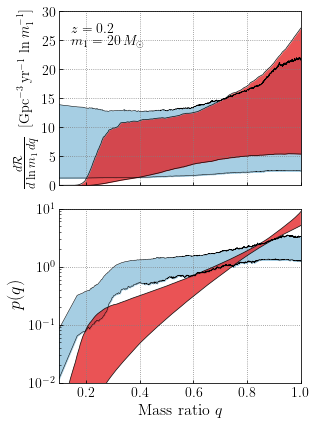

In [167]:
fig = plt.figure(figsize=(4.5,6))

ax = fig.add_subplot(211)
ax.set_rasterization_zorder(1)

ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.5)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),
                np.quantile(dR_dqs_lnm20,0.95,axis=1),
                color='#a6cee3',zorder=-1)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-30.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*30.

ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_q_grid,
                np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)
ax.set_xticklabels([])

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(212)
ax.set_rasterization_zorder(1)

ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5)
ax.fill_between(qs,np.quantile(p_qs,0.05,axis=1),
                np.quantile(p_qs,0.95,axis=1),
                color='#a6cee3',zorder=-1)

lvk_R_qs = np.trapz(lvk_R_m1s_qs,lvk_m1_grid,axis=2)
lvk_p_qs = np.array([lvk_R_qs[i,:]/np.trapz(lvk_R_qs[i,:],lvk_q_grid) for i in range(lvk_R_qs.shape[0])])

#lvk_p_qs = lvk_dR_dq_lnm20/np.trapz(lvk_dR_dq_lnm20,lvk_q_grid,axis=1)[:,np.newaxis]
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=2)
ax.fill_between(lvk_q_grid,
                np.quantile(lvk_p_qs,0.05,axis=0),
                np.quantile(lvk_p_qs,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=1,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
#ax.set_ylim(0,6)

ax.set_ylim(1e-2,1e1)
ax.set_yscale('log')

ax.set_xlabel('Mass ratio $q$',fontsize=16)
ax.set_ylabel('$p(q)$',fontsize=18)

plt.tight_layout()
plt.savefig('q_rate_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

0.8482222222222222


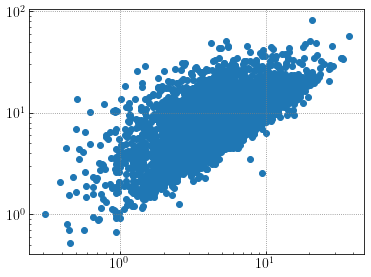

In [58]:
ind_q04 = np.argmin(np.abs(qs-0.4))
ind_q05 = np.argmin(np.abs(qs-0.5))
ind_q09 = np.argmin(np.abs(qs-0.9))
ind_q10 = np.argmin(np.abs(qs-1.0))

R_04 = dR_dqs_lnm20[ind_q04,:]
R_05 = dR_dqs_lnm20[ind_q05,:]
R_09 = dR_dqs_lnm20[ind_q09,:]
R_10 = dR_dqs_lnm20[ind_q10,:]

mean_R_04_to_05 = np.trapz(dR_dqs_lnm20[ind_q04:ind_q05,:],np.log10(m1s[ind_q04:ind_q05]),axis=0)/\
    np.trapz(np.ones(np.log10(m1s[ind_q04:ind_q05]).size),np.log10(m1s[ind_q04:ind_q05]))

mean_R_09_to_10 = np.trapz(dR_dqs_lnm20[ind_q09:ind_q10,:],np.log10(m1s[ind_q09:ind_q10]),axis=0)/\
    np.trapz(np.ones(np.log10(m1s[ind_q09:ind_q10]).size),np.log10(m1s[ind_q09:ind_q10]))

fig,ax = plt.subplots()
ax.scatter(mean_R_04_to_05,mean_R_09_to_10)
ax.set_xscale('log')
ax.set_yscale('log')

print(mean_R_09_to_10[mean_R_09_to_10>mean_R_04_to_05].size/mean_R_09_to_10.size)

#print(np.mean(slope_15_to_25),np.mean(slope_45_to_70),np.sum(slope_45_to_70<slope_15_to_25)/slope_15_to_25.size)

In [ ]:
p_qs = np.zeros((qs.size,f_lnm1s.shape[1]))

Q,M1 = np.meshgrid(qs,m1s)
M2 = Q*M1

for i in range(f_lnm1s.shape[1]):
    
    R = R_ref.values[i]*np.outer(f_lnm1s[:,i],f_qs[:,i])
    R[M2<2] = 0
    
    p_q = np.trapz(R,m1s,axis=0)
    p_q /= np.trapz(p_q,qs)
    p_qs[:,i] = p_q

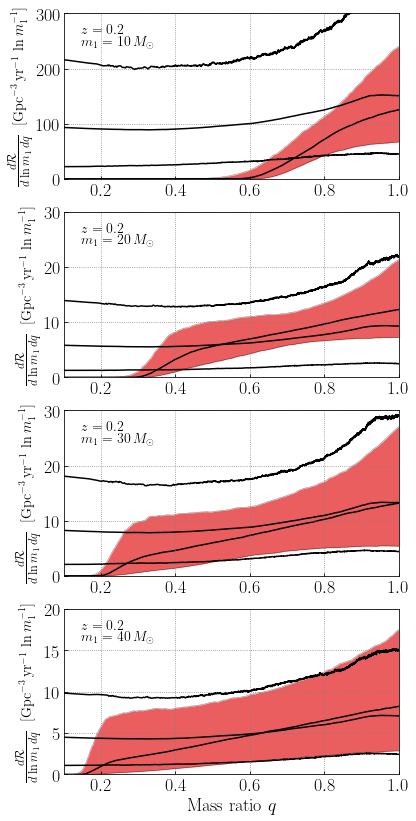

In [175]:
fig = plt.figure(figsize=(6,14))

ax = fig.add_subplot(411)

ind_m10 = np.argmin(np.abs(m1s-10.))
p_q_m = f_qs*R_ref*f_lnm1s[ind_m10,:]
ax.plot(qs,np.mean(p_q_m,axis=1),color='black')
ax.plot(qs,np.quantile(p_q_m,0.05,axis=1),color='black')
ax.plot(qs,np.quantile(p_q_m,0.95,axis=1),color='black')

ind_m20 = np.argmin(np.abs(lvk_m1_grid-10.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*10.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,300)
ax.text(0.05,0.83,r'$m_1=10\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(412)

ind_m10 = np.argmin(np.abs(m1s-20.))
p_q_m = f_qs*R_ref*f_lnm1s[ind_m10,:]
ax.plot(qs,np.mean(p_q_m,axis=1),color='black')
ax.plot(qs,np.quantile(p_q_m,0.05,axis=1),color='black')
ax.plot(qs,np.quantile(p_q_m,0.95,axis=1),color='black')

ind_m20 = np.argmin(np.abs(lvk_m1_grid-20.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*20.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)
ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(413)

ind_m10 = np.argmin(np.abs(m1s-30.))
p_q_m = f_qs*R_ref*f_lnm1s[ind_m10,:]
ax.plot(qs,np.mean(p_q_m,axis=1),color='black')
ax.plot(qs,np.quantile(p_q_m,0.05,axis=1),color='black')
ax.plot(qs,np.quantile(p_q_m,0.95,axis=1),color='black')

ind_m20 = np.argmin(np.abs(lvk_m1_grid-30.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*30.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)
ax.text(0.05,0.83,r'$m_1=30\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(414)

ind_m10 = np.argmin(np.abs(m1s-40.))
p_q_m = f_qs*R_ref*f_lnm1s[ind_m10,:]
ax.plot(qs,np.mean(p_q_m,axis=1),color='black')
ax.plot(qs,np.quantile(p_q_m,0.05,axis=1),color='black')
ax.plot(qs,np.quantile(p_q_m,0.95,axis=1),color='black')

ind_m20 = np.argmin(np.abs(lvk_m1_grid-40.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*40.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,20)
ax.text(0.05,0.83,r'$m_1=40\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Mass ratio $q$',fontsize=18)


plt.savefig('lvk_mass_ratios.pdf',bbox_inches='tight',dpi=200)
plt.show()

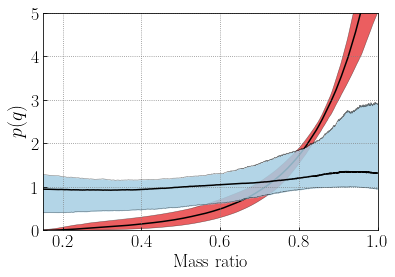

In [66]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.fill_between(qs,np.quantile(p_qs,0.05,axis=1),np.quantile(p_qs,0.95,axis=1),color='#a6cee3',lw=0.15,alpha=0.85)

lvk_R_qs = np.trapz(lvk_R_m1s_qs,lvk_m1_grid,axis=2)
lvk_p_qs = np.array([lvk_R_qs[i,:]/np.trapz(lvk_R_qs[i,:],lvk_q_grid) for i in range(lvk_R_qs.shape[0])])

ax.plot(lvk_q_grid,np.median(lvk_p_qs,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_p_qs,0.05,axis=0),
                np.quantile(lvk_p_qs,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=18)
ax.set_xlim(0.15,1)
ax.set_ylim(0,5)

ax.set_xlabel('Mass ratio',fontsize=18)
ax.set_ylabel(r'$p(q)$',fontsize=20)

plt.savefig('q_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()